In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import scipy.io as sio
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy.spatial import distance as scipy_dist
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

from collections import defaultdict



from cmep import predict_iq_cmep
from cpm import CPM
from utils import load_orig_data, load_raw_data, fisher_z_transform, calc_all_metrics, control_connectivities

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

NETWORKS = {
    "VIS": [(0, 4), (56, 60)],
    "SMN": [(5, 9), (61, 65)],
    "DAN": [(10, 16), (66, 72)],
    "VAN": [(17, 26), (73, 85)],
    "LIM": [(27, 28), (86, 87)],
    "CON": [(29, 42), (88, 99)],
    "DMN": [(43, 55), (100, 112)]
}

In [2]:
# (f'{inp_path}/data/NKI/FCstatic_all.mat')
inp_path = '/Users/maren/Downloads/data_NKI_backup'#'../../MA'
static_con, _, fs_iq, controls = load_orig_data(inp_path, load_dyn=False)
raw_645_zscored = load_raw_data(inp_path) ## is in same order as sFC & fs_iq

Loading the original data ...
Done


In [222]:
stat_con_fz = fisher_z_transform(static_con)
stat_con_cont = control_connectivities(stat_con_fz, controls[:, -1])

Fisher Z transformation
Control connectivity


In [7]:
def split_data(raw):
    nb_samples, nb_nodes, nb_tfs = raw.shape
    halb_nb_tfs = nb_tfs // 2
    sFC_one, sFC_two = np.zeros((nb_samples, nb_nodes, nb_nodes)), np.zeros((nb_samples, nb_nodes, nb_nodes))
    for sample_i in range(nb_samples):
        sFC_one[sample_i] = np.corrcoef(raw[sample_i, :, :halb_nb_tfs])
        sFC_two[sample_i] = np.corrcoef(raw[sample_i, :, halb_nb_tfs:])
    return sFC_one, sFC_two

In [ ]:
sFC_one, sFC_two = split_data(raw_645_zscored)

In [8]:
def calc_distance_similarity(sFC_one, sFC_two):
    nb_samples, nb_nodes, _ = sFC_one.shape
    similiarity, distance = np.zeros((nb_samples, nb_samples)), np.zeros((nb_samples, nb_samples))
    triu_indices = np.triu_indices(nb_nodes, k = 1)
    for sample_i, sample_i_FC in enumerate(sFC_one):
        sample_i_triu = sample_i_FC[triu_indices]
        for sample_j, sample_j_FC in enumerate(sFC_two):
            sample_j_triu = sample_j_FC[triu_indices]
            r, p = pearsonr(sample_i_triu, sample_j_triu)
            similiarity[sample_i, sample_j] = r
            distance[sample_i, sample_j] = scipy_dist.cosine(sample_i_triu, sample_j_triu)
    return similiarity, distance
            

In [13]:
similarity, distance = calc_distance_similarity(sFC_one, sFC_two)

In [9]:
def calc_identifiability(sim_or_dist):
    nb_samples = len(sim_or_dist)
    trace = np.trace(sim_or_dist)
    i_self = trace / nb_samples
    i_others = (np.sum(sim_or_dist) - trace) / ((nb_samples-1)*nb_samples)
                     
    i_diff = (i_self - i_others) * 100
    return i_diff

In [15]:
i_diff_sim = calc_identifiability(similarity)
i_diff_dis = calc_identifiability(distance)

In [16]:
print(i_diff_sim, i_diff_dis)

27.07108840083961 -26.999653076825247


In [3]:
def create_templates(networks, nb_nodes):
    nb_nws = len(networks)
    templates = []
    temp = np.zeros((nb_nodes, nb_nodes))
    for i in range(1, 4): #nb_nws+1):
        for selected_nws in itertools.combinations(networks.keys(), i):
            print(selected_nws, end='; ')
            temp *= 0
            for nw in list(selected_nws):
                regions = networks[nw]
                for (start, end) in regions:
                    temp[start:end+1] += 1
                    temp[:, start:end+1] += 1
            temp[np.where(temp>1)] = 0
            templates.append(temp.copy())
    return templates
        
    

In [4]:
templates = create_templates(NETWORKS, nb_nodes=113)

('VIS',); ('SMN',); ('DAN',); ('VAN',); ('LIM',); ('CON',); ('DMN',); ('VIS', 'SMN'); ('VIS', 'DAN'); ('VIS', 'VAN'); ('VIS', 'LIM'); ('VIS', 'CON'); ('VIS', 'DMN'); ('SMN', 'DAN'); ('SMN', 'VAN'); ('SMN', 'LIM'); ('SMN', 'CON'); ('SMN', 'DMN'); ('DAN', 'VAN'); ('DAN', 'LIM'); ('DAN', 'CON'); ('DAN', 'DMN'); ('VAN', 'LIM'); ('VAN', 'CON'); ('VAN', 'DMN'); ('LIM', 'CON'); ('LIM', 'DMN'); ('CON', 'DMN'); ('VIS', 'SMN', 'DAN'); ('VIS', 'SMN', 'VAN'); ('VIS', 'SMN', 'LIM'); ('VIS', 'SMN', 'CON'); ('VIS', 'SMN', 'DMN'); ('VIS', 'DAN', 'VAN'); ('VIS', 'DAN', 'LIM'); ('VIS', 'DAN', 'CON'); ('VIS', 'DAN', 'DMN'); ('VIS', 'VAN', 'LIM'); ('VIS', 'VAN', 'CON'); ('VIS', 'VAN', 'DMN'); ('VIS', 'LIM', 'CON'); ('VIS', 'LIM', 'DMN'); ('VIS', 'CON', 'DMN'); ('SMN', 'DAN', 'VAN'); ('SMN', 'DAN', 'LIM'); ('SMN', 'DAN', 'CON'); ('SMN', 'DAN', 'DMN'); ('SMN', 'VAN', 'LIM'); ('SMN', 'VAN', 'CON'); ('SMN', 'VAN', 'DMN'); ('SMN', 'LIM', 'CON'); ('SMN', 'LIM', 'DMN'); ('SMN', 'CON', 'DMN'); ('DAN', 'VAN', 'LIM

In [5]:
len(templates)

63

In [6]:
def plot_templates_inputs(NETWORKS):
    binary_nw_selection = []
    for i in range(1, 4): #nb_nws+1):
        for selected_nws in itertools.combinations(np.arange(len(NETWORKS.keys())), i):
            nw_selection = np.zeros(7)
            nw_selection[list(selected_nws)] = 1
            binary_nw_selection.append(nw_selection)
    plt.matshow(np.array(binary_nw_selection).T)
    plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
    return np.array(binary_nw_selection)

                

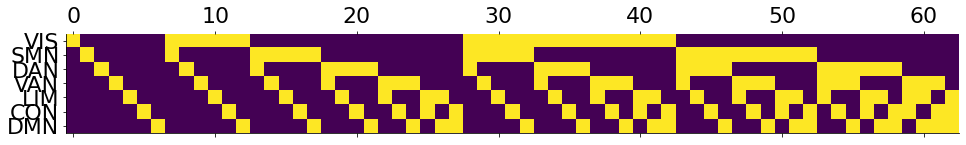

In [7]:
binary_nw_selection = plot_templates_inputs(NETWORKS)

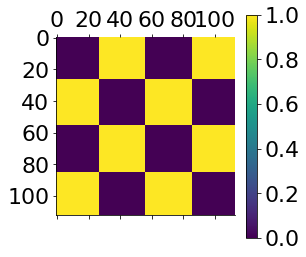

In [48]:
plt.matshow(templates[-1])
plt.colorbar()

In [8]:
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import jaccard
triu_indices = np.triu_indices(113, k = 1)
temp_0 = templates[0][triu_indices].astype(int)+ 1
mut_infos_scipy, jacc_distance = [], []
for frame in range(0, 884):
    #frame = 200
    sample_frame = np.outer(raw_645_zscored[0][:, frame], raw_645_zscored[0][:, frame])
    samp_fram = np.where(sample_frame > 0, 2, 1)
    sample_frame = samp_fram[triu_indices]
    # _, mut_info = partition_distance(sample_frame, temp_0)
    # mut_infos.append(mut_info)
    mut_info = mutual_info_score(sample_frame, temp_0)
    mut_infos_scipy.append(mut_info)
    
    #samp_fram = np.where(sample_frame > 0, 1, 0)
    #sample_frame = samp_fram[triu_indices]
    iou = jaccard(sample_frame - 1, temp_0 - 1) # to put values between 0 & 1
    jacc_distance.append(iou)

(0.7961630114044991, 1.2248225027480864e-194)


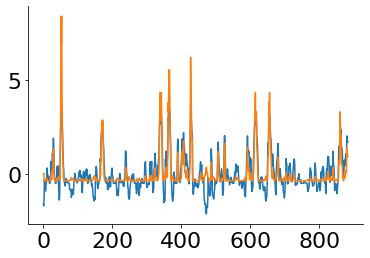

In [13]:
normalize = lambda v: (v - np.mean(v)) / np.std(v)
plt.plot(normalize(jacc_distance))
plt.plot(normalize(mut_infos_scipy))
print(pearsonr(jacc_distance, mut_infos_scipy))

In [50]:
MIframes = sio.loadmat('/Users/Maren/Downloads/bipartitions code package/MIframes.mat')['MIframes']
MItemplates = sio.loadmat('/Users/Maren/Downloads/bipartitions code package/MItemplates.mat')['MItemplates']
maxMI = sio.loadmat('/Users/Maren/Downloads/bipartitions code package/maxMI.mat')['maxMI']
bestmatch = sio.loadmat('/Users/Maren/Downloads/bipartitions code package/bestmatch.mat')['bestmatch']

In [40]:
example_ts = sio.loadmat('/Users/Maren/Downloads/bipartitions code package/example_timeseries.mat')['ts'].T
template_200 = sio.loadmat('/Users/Maren/Downloads/bipartitions code package/template_basis_set_200.mat')['cit']


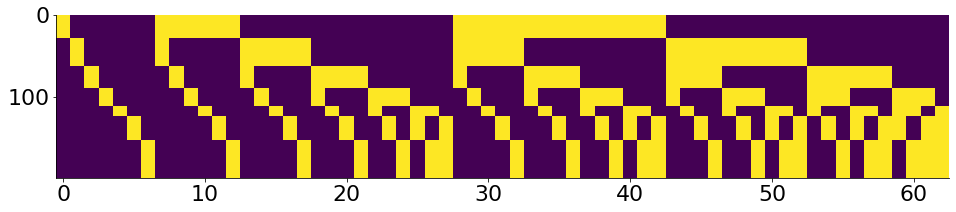

In [31]:
plt.figure(figsize=(16,3))
plt.imshow(template_200, aspect='auto', interpolation='None')

In [36]:
template_200.shape

(200, 63)

In [42]:
temp_0 = template_200[:, 0]
mut_infos_scipy_sporns, jacc_distance_sporns = [], []
for frame in range(0, example_ts.shape[-1]):
    #frame = 200
    # sample_frame = np.outer(raw_645_zscored[0][:, frame], raw_645_zscored[0][:, frame])
    # samp_fram = np.where(sample_frame > 0, 2, 1)
    # sample_frame = samp_fram[triu_indices]
    sample_frame = np.where(example_ts[:, frame] > 0, 2, 1)
    # _, mut_info = partition_distance(sample_frame, temp_0)
    # mut_infos.append(mut_info)
    mut_info = mutual_info_score(sample_frame, temp_0)
    mut_infos_scipy_sporns.append(mut_info)
    
    #samp_fram = np.where(sample_frame > 0, 1, 0)
    #sample_frame = samp_fram[triu_indices]
    iou = jaccard(sample_frame - 1, temp_0 - 1) # to put values between 0 & 1
    jacc_distance_sporns.append(iou)

(-0.208322944137218, 2.9913068478880168e-12)
(0.9998939861471554, 0.0)


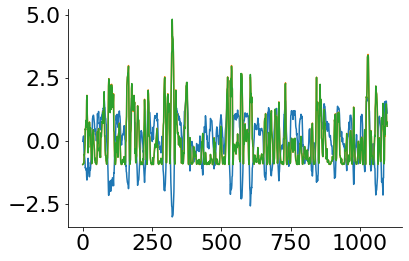

In [46]:
plt.plot(normalize(jacc_distance_sporns))
plt.plot(normalize(mut_infos_scipy_sporns))
plt.plot(normalize(MItemplates[:, 0]))
print(pearsonr(jacc_distance_sporns, mut_infos_scipy_sporns))
print(pearsonr(MItemplates[:, 0], mut_infos_scipy_sporns))

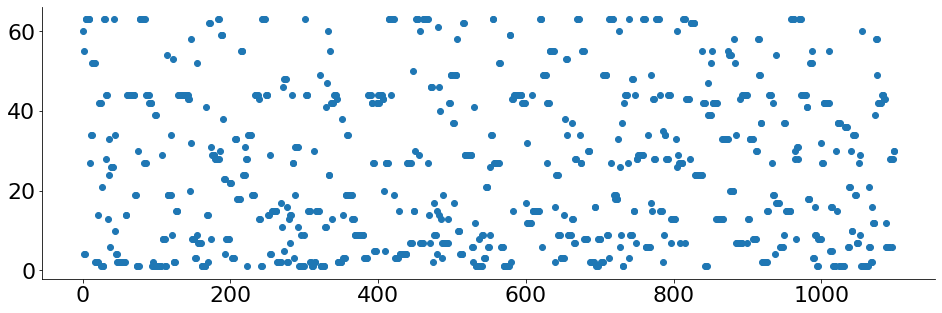

In [54]:
plt.figure(figsize=(16,5))
plt.scatter(np.arange(len(bestmatch.squeeze())), bestmatch.squeeze())

In [60]:
def create_templates_200nodes(template_200):
    nb_nodes = 200
    templates_2d = []
    for temp_ in template_200.T:
        nws = np.where(temp_ == 2)
        new_temp = np.zeros((nb_nodes, nb_nodes))
        new_temp[nws] += 1
        new_temp[:, nws] += 1
        new_temp[new_temp > 1] = 0
        templates_2d.append(new_temp)
    return templates_2d

In [61]:
templates_2d = create_templates_200nodes(template_200)

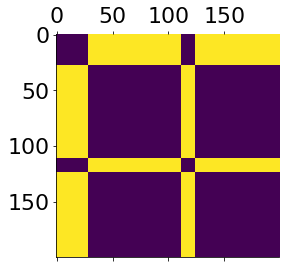

In [65]:
plt.matshow(templates_2d[10])

In [68]:
mut_infos_2d, jacc_distance_2d = [], []
triu_indices = np.triu_indices(200, k = 1)
temp_0 =  templates_2d[0][triu_indices].astype(int)+ 1
for frame in range(0, example_ts.shape[-1]):
    sample_frame = np.outer(example_ts[:, frame], example_ts[:, frame])
    sample_frame = sample_frame[triu_indices]
    sample_frame = np.where(sample_frame > 0, 2, 1)
    
    mut_info = mutual_info_score(sample_frame, temp_0)
    mut_infos_2d.append(mut_info)
    
    iou = jaccard(sample_frame - 1, temp_0 - 1) # to put values between 0 & 1
    jacc_distance_2d.append(iou)

(0.7779234361233434, 8.367799660723151e-224)

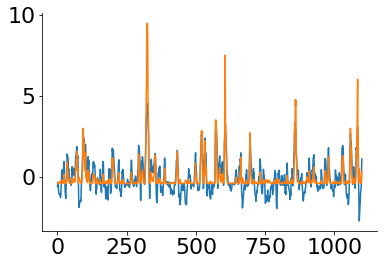

In [71]:
plt.plot(normalize(jacc_distance_2d))
plt.plot(normalize(mut_infos_2d))
pearsonr(jacc_distance_2d, mut_infos_2d)

In [70]:
pearsonr(mut_infos_2d, mut_infos_scipy_sporns)

(0.6045427080133419, 1.3962315435110407e-110)

Text(0.5, 0, 'Frame')

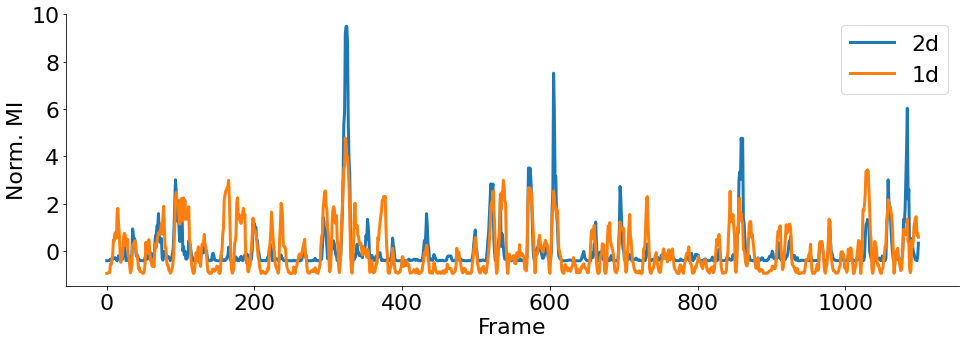

In [78]:
plt.figure(figsize=(16,5))
plt.plot(normalize(mut_infos_2d), linewidth=3,label='2d')
plt.plot(normalize(mut_infos_scipy_sporns), linewidth=3, label='1d')
plt.legend()
plt.ylabel('Norm. MI')
plt.xlabel('Frame')

In [350]:
mut_info_cluster = sio.loadmat('./mutual_information_results/Mutual_infos_NKI_Bipartitioned_0_884.mat')['mutual_infos']

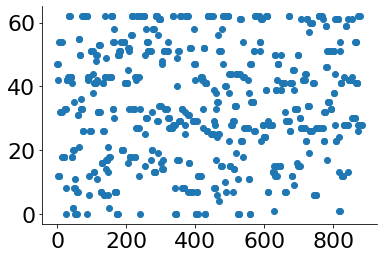

In [356]:
plt.scatter(np.arange(884), np.argmax(mut_info_cluster[:,0], axis=0))

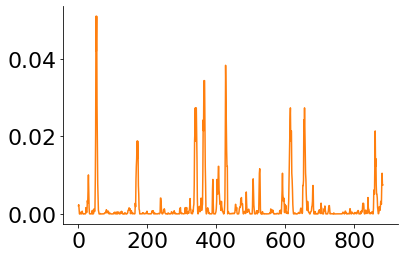

In [343]:
plt.plot(np.array(mut_infos) + 2)
plt.plot(mut_infos_scipy)

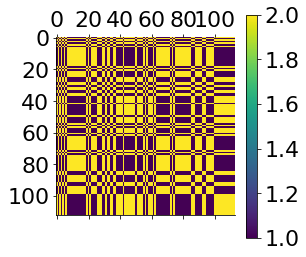

In [307]:
plt.matshow(samp_fram)
plt.colorbar()

In [344]:
def calc_temp_sim_mats(templates, raw, start, end, nb_frames):
    nb_samples, nb_nodes, nb_tfs = raw.shape

    mutual_infos = np.zeros((len(templates), nb_samples, end - start))
    template_matched_fc = np.zeros((len(templates), nb_samples, nb_nodes, nb_nodes))
    triu_indices = np.triu_indices(nb_nodes, k = 1)
    for sample_i, sample_raw in enumerate(raw):
        # if sample_i % 20 == 0:
        print(sample_i, end='; ')
        eFC = np.zeros((nb_nodes, nb_nodes, end - start))
        eFC_long = np.zeros((nb_nodes * (nb_nodes-1) // 2, end - start))
        
        for f, frame in enumerate(range(start, end)):
            eFC[..., f] = np.outer(sample_raw[:, frame], sample_raw[:, frame])
            # bipartition
            eFC[..., f] = np.where(eFC[..., f]  > 0,2,1)
            eFC_long[..., f] = eFC[..., f][triu_indices]
        if sample_i == 0:
            print(eFC_long.shape)
        for t, template in enumerate(templates):
            mi = []
            for f in range(eFC.shape[-1]):
                # _, mut_info = partition_distance(eFC_long[..., f].astype(int), template[triu_indices].astype(int) + 1)
                mut_info = mutual_info_score(eFC_long[..., f].astype(int), template[triu_indices].astype(int) + 1)
                mi.append(mut_info)
            mi = np.array(mi)
            # mi = mutual_info_classif(eFC_long, template[triu_indices])
            highest_mi = np.argsort(mi)[-nb_frames:] # nb_frames with highest mutual information frames
            template_matched_fc[t, sample_i] = np.sum(eFC[..., highest_mi], axis=-1)
    return mutual_infos, template_matched_fc
        
def partition_distance(cx, cy):
    '''
    This function quantifies the distance between pairs of community
    partitions with information theoretic measures.
    Inputs:         Cx,         Community affiliation vector X
                    Cy,         Community affiliation vector Y
    Outputs:        VIn,        Normalized variation of information
                    MIn,        Normalized mutual information
    (Definitions:
       VIn = [H(X) + H(Y) - 2MI(X,Y)]/log(n)
       MIn = 2MI(X,Y)/[H(X)+H(Y)]
    where H is entropy, MI is mutual information and n is number of nodes)
    '''
    n = np.size(cx)
    _, cx = np.unique(cx, return_inverse=True)
    _, cy = np.unique(cy, return_inverse=True)
    _, cxy = np.unique(cx + cy * 1j, return_inverse=True)

    Px = np.histogram(cx, bins=np.max(cx))[0] / n
    Py = np.histogram(cy, bins=np.max(cy))[0] / n
    Pxy = np.histogram(cxy, bins=np.max(cxy) + 1)[0] / n

    Hx = -np.sum(Px * np.log(Px))
    Hy = -np.sum(Py * np.log(Py))
    Hxy = -np.sum(Pxy * np.log(Pxy))

    Vin = (2 * Hxy - Hx - Hy) / np.log(n)
    Min = 2 * (Hx + Hy - Hxy) / (Hx + Hy)
    return Vin, Min   

In [345]:
start = 0
end = 1 # raw_645_zscored.shape[-1] // 10
nb_frames = int((end - start) *.1)
mutual_infos_one, template_matched_fc_one = calc_temp_sim_mats(templates, raw_645_zscored, start, end, nb_frames)

0; (6328, 1)
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 100; 101; 102; 103; 104; 105; 106; 107; 108; 109; 110; 111; 112; 113; 114; 115; 116; 117; 118; 119; 120; 121; 122; 123; 124; 125; 126; 127; 128; 129; 130; 131; 132; 133; 134; 135; 136; 137; 138; 139; 140; 141; 142; 143; 144; 145; 146; 147; 148; 149; 150; 151; 152; 153; 154; 155; 156; 157; 158; 159; 160; 161; 162; 163; 164; 165; 166; 167; 168; 169; 170; 171; 172; 173; 174; 175; 176; 177; 178; 179; 180; 181; 182; 183; 184; 185; 186; 187; 188; 189; 190; 191; 192; 193; 194; 195; 196; 197; 198; 199; 200; 201; 202; 203; 204; 205; 206; 207; 208; 209; 210; 211; 212; 213; 214; 215; 216; 217; 218; 219; 

In [346]:
np.sum(mutual_infos_one)

0.0

## Load Mutual Info

In [238]:
def load_mutual_information(inp_dir, nb_templates, nb_samples, nb_tfs, save_name):
    if 'Bipart' in save_name:
        files = sorted([f for f in os.listdir(inp_dir) if save_name in f])
    else:
        files = sorted([f for f in os.listdir(inp_dir) if save_name in f and 'Bipart' not in f])
    print(files)
    mi = np.zeros((nb_templates, nb_samples, nb_tfs))
    for file in files:
        start, end = int(file.split('_')[-2]), int(file.split('_')[-1].split('.')[0])
        print(start, end)
        mi[..., start:end] = sio.loadmat(os.path.join(inp_dir, file))['mutual_infos']
    return mi
        
    
    

In [235]:
nb_templates, nb_samples, nb_tfs = 63, 281, 884
save_name = 'NKI'
mi = load_mutual_information('./mutual_information_results/', nb_templates, nb_samples, nb_tfs, save_name)

['Mutual_infos_NKI_0_100.mat', 'Mutual_infos_NKI_100_200.mat', 'Mutual_infos_NKI_200_300.mat', 'Mutual_infos_NKI_300_400.mat', 'Mutual_infos_NKI_400_500.mat', 'Mutual_infos_NKI_500_600.mat', 'Mutual_infos_NKI_600_700.mat', 'Mutual_infos_NKI_700_800.mat', 'Mutual_infos_NKI_800_884.mat']
0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 884


In [239]:
save_name = 'NKI_Bipart'
mi_bipart = load_mutual_information('./mutual_information_results/', nb_templates, nb_samples, nb_tfs, save_name)

['Mutual_infos_NKI_Bipartitioned_0_100.mat', 'Mutual_infos_NKI_Bipartitioned_100_300.mat', 'Mutual_infos_NKI_Bipartitioned_300_500.mat', 'Mutual_infos_NKI_Bipartitioned_500_700.mat', 'Mutual_infos_NKI_Bipartitioned_700_884.mat']
0 100
100 300
300 500
500 700
700 884


In [245]:
iou = sio.loadmat('./mutual_information_results/IOU_NKI_Bipartitioned_0_884.mat')['mutual_infos']

In [269]:
np.sum(mutual_infos_one)

0.0

(-0.21282058242890584, 1.63705934099383e-10)

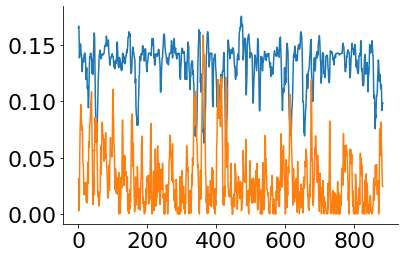

In [253]:
plt.plot(iou[0, 0])
plt.plot(mi[0, 0])
pearsonr(mi[3, 0], iou[3,0])

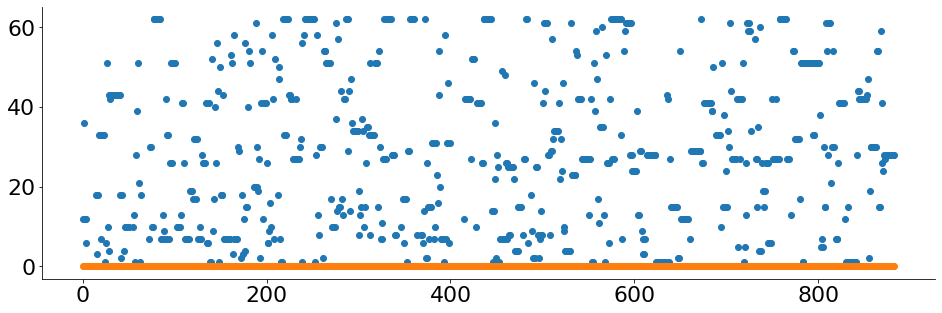

In [240]:

# plt.plot(mi[0, 0, ...])
#plt.plot(mi[1, 0, 800:])
plt.figure(figsize=(16,5))
plt.scatter(np.arange(0, 884), np.argmax(mi[:, 0], axis=0))
plt.scatter(np.arange(0, 884), np.argmax(mi_bipart[:, 0], axis=0))

In [18]:
def calc_rss(raw):
    nb_samples, nb_nodes, nb_dyns = raw.shape
    rss = np.zeros((nb_samples, nb_dyns))
    for sample_i in range(nb_samples):
        raw_sample = raw[sample_i]  
        
        co_fluct = np.zeros((nb_nodes, nb_nodes, nb_dyns))
        co_fluct_lower = np.zeros((nb_nodes, nb_nodes, nb_dyns))
        for t in range(nb_dyns):
            co_fluct[:, :, t] = np.outer(raw_sample[:, t], raw_sample[ :, t])
            co_fluct_lower[:, :, t] = np.tril(co_fluct[:, :, t])
        
        rss_sample = np.sqrt(np.sum(co_fluct_lower.reshape(nb_nodes * nb_nodes, nb_dyns) ** 2, axis=0))
        rss[sample_i] = rss_sample
    return rss

rss_all = calc_rss(raw_645_zscored)

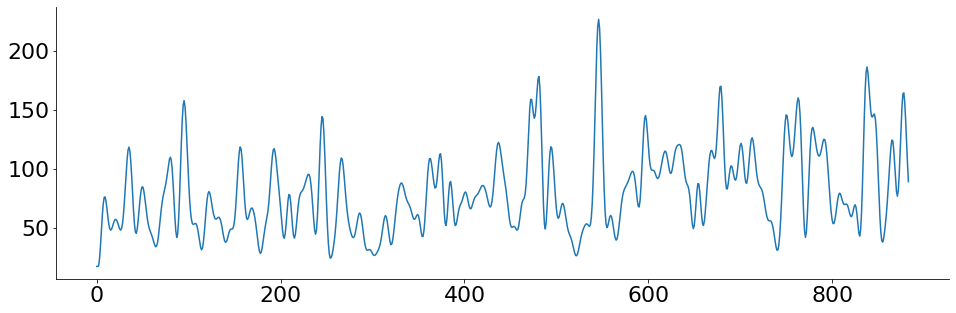

In [19]:
plt.figure(figsize=(16,5))
plt.plot(rss_all[0])

In [25]:
def select_tfs(rss, nb_tfs=44):
    extrema = []
    df = pd.DataFrame(rss, columns=['data'])
    df['min'] = df.data[(df.data.shift(1) > df.data) & (df.data.shift(-1) > df.data)]
    df['max'] = df.data[(df.data.shift(1) < df.data) & (df.data.shift(-1) < df.data)]
    
    maxima_indices = np.where(np.abs(df['max']) > 0)[0]
    maxima_rss_sorted_indices = np.argsort(rss[maxima_indices])[::-1]
    mx = maxima_indices[maxima_rss_sorted_indices][:nb_tfs]
    
    
    minima_indices = np.where(np.abs(df['min']) > 0)[0]
    minima_rss_sorted_indices = np.argsort(rss[minima_indices])
    mn = minima_indices[minima_rss_sorted_indices][:nb_tfs]
    
    sorted_rss_indices = np.argsort(rss)
    hiCo = sorted_rss_indices[-nb_tfs:]
    loCo = sorted_rss_indices[:nb_tfs]
    
    
    return hiCo, loCo, mx, mn

In [38]:
selected_tfs = []
for sample_rss in rss_all:
    selected_tfs.append(select_tfs(sample_rss, nb_tfs=44))

In [39]:
mx_templates = np.argmax(mi[:, 0, selected_tfs[0][2]], axis=0)

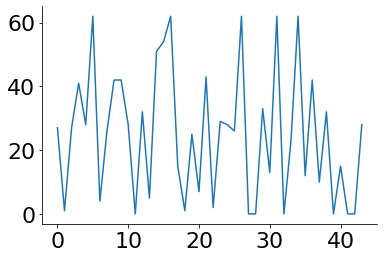

In [40]:
plt.plot(mx_templates)

In [41]:
mx_tmp = np.mean(np.array(templates)[mx_templates], axis=0)

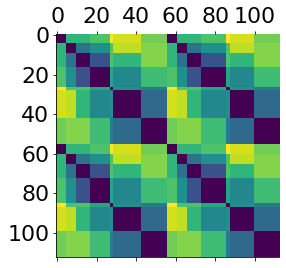

In [42]:
plt.matshow(mx_tmp)

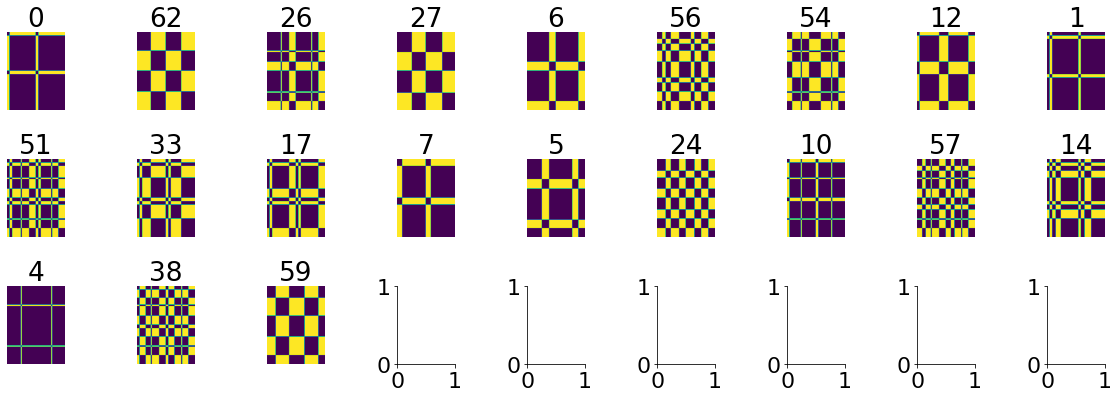

In [80]:
# templates during maxima

from collections import Counter
from itertools import repeat, chain
sample_i = 8
row, col = 0, 0
mx_templates = np.argmax(mi[:, sample_i, selected_tfs[sample_i][2]], axis=0)
mx_templates = list(chain.from_iterable(repeat(i, c) for i,c in Counter(mx_templates).most_common()))
fig, ax = plt.subplots(figsize=(16, 6), nrows=len(np.unique(mx_templates))//9+1, ncols=9)
for i, mx_template in enumerate(mx_templates):
    if i == 0:
        last_template = mx_template
    else:
        if last_template == mx_template:
            continue
        else:
            last_template = mx_template
    mx_tmp = templates[mx_template]
    ax[row, col].imshow(mx_tmp, aspect='auto')
    ax[row, col].axis('off')
    ax[row, col].set_title(mx_template)
    col += 1
    if col == 9:
        col = 0
        row += 1
plt.tight_layout()
# plt.matshow(mx_tmp)

In [101]:

def count_templates_present(mutual_info):
    temps_present = defaultdict(int)
    temps_numbers = defaultdict(list)
    nb_templates, nb_samples, _ = mutual_info.shape
    for s in range(nb_samples):
        sample_temps = np.argmax(mutual_info[:, s], axis=0)
        unique_templates = np.unique(sample_temps)
        for temp in range(nb_templates):
            if temp in unique_templates:
                temps_present[temp] += 1
            temps_numbers[temp].append(len(np.where(sample_temps == temp)[0]))
    return temps_present, temps_numbers

In [358]:
temps_present, temps_numbers = count_templates_present(mi)
temps_present_new, temps_numbers_new = count_templates_present(mut_info_cluster)

Text(0.5, 1.0, 'Discrete feats')

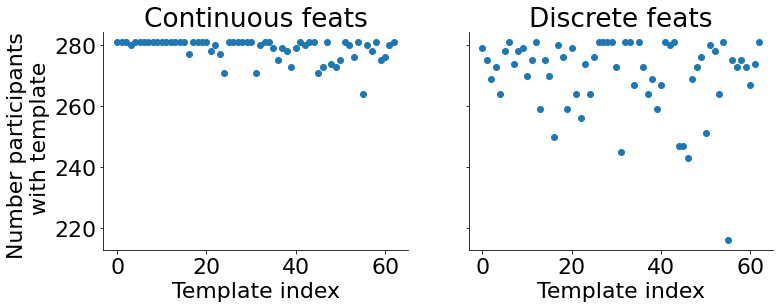

In [360]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2, sharey=True)
ax[0].scatter(temps_present.keys(), temps_present.values())
ax[1].scatter(temps_present_new.keys(), temps_present_new.values())
ax[0].set_xlabel('Template index')
ax[1].set_xlabel('Template index')
ax[0].set_ylabel('Number participants \n with template')
ax[0].set_title('Continuous feats')
ax[1].set_title('Discrete feats')

Text(0.5, 1.0, 'Discrete feats')

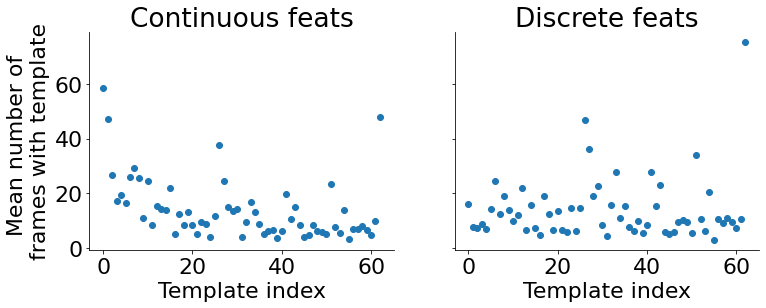

In [361]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2, sharey=True)
mean_temp_nb = []
std_temp_nb = []
for temp in range(len(templates)):
    mean_temp_nb.append(np.mean(temps_numbers[temp]))
    std_temp_nb.append(np.std(temps_numbers[temp]))
ax[0].scatter(np.arange(len(mean_temp_nb)), mean_temp_nb)

mean_temp_nb = []
std_temp_nb = []
for temp in range(len(templates)):
    mean_temp_nb.append(np.mean(temps_numbers_new[temp]))
    std_temp_nb.append(np.std(temps_numbers_new[temp]))
ax[1].scatter(np.arange(len(mean_temp_nb)), mean_temp_nb)

ax[0].set_xlabel('Template index')
ax[1].set_xlabel('Template index')
ax[0].set_ylabel('Mean number of \nframes with template')
ax[0].set_title('Continuous feats')
ax[1].set_title('Discrete feats')

In [363]:
temps_numbers_array = []
for temp in temps_numbers:
    temps_numbers_array.append(temps_numbers[temp])
temps_numbers_array = np.array(temps_numbers_array)

temps_numbers_array_new = []
for temp in temps_numbers:
    temps_numbers_array_new.append(temps_numbers_new[temp])
temps_numbers_array_new = np.array(temps_numbers_array_new)

Text(0.5, 1.0, 'Discrete feats')

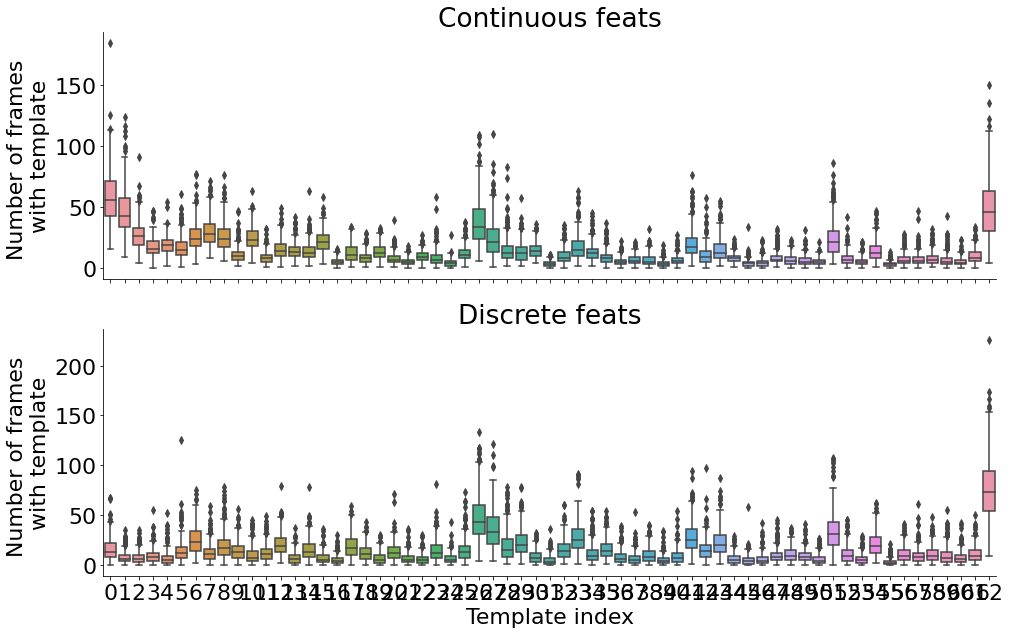

In [365]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=2, sharex=True)
sns.boxplot(data=temps_numbers_array.T, ax=ax[0])
sns.boxplot(data=temps_numbers_array_new.T, ax=ax[1])
ax[1].set_xlabel('Template index')
ax[0].set_ylabel('Number of frames \nwith template')
ax[1].set_ylabel('Number of frames \nwith template')
ax[0].set_title('Continuous feats')
ax[1].set_title('Discrete feats')

In [366]:
def create_fc_from_template(raw, template_i, mi, nb_tfs, reconst_method):
    nb_samples, nb_nodes, _ = raw.shape
    template_FC = np.zeros((nb_samples, nb_nodes, nb_nodes))
    for sample_i in range(nb_samples):
        raw_sample = raw[sample_i]
        sample_mi = mi[template_i, sample_i]  # shape: nb tfs of whole ts
        selected_tfs = np.argsort(sample_mi)[-nb_tfs:] # highest mi
        if reconst_method == 'corr':
            template_FC[sample_i] = np.corrcoef(raw_sample[:, selected_tfs])
        elif reconst_method == 'sum':
            for selected_tf in selected_tfs:
                template_FC[sample_i] += np.outer(raw_sample[:, selected_tf], raw_sample[:, selected_tf])
    return template_FC
    
    
def predict_from_template(templates, raw, iq, mi, nb_tfs, control=None, reconst_method='corr', model='cmep'):
    results = []
    for t, template in enumerate(templates):
        print(t, end=': ')
        template_FC = create_fc_from_template(raw, t, mi, nb_tfs, reconst_method)
        if reconst_method == 'corr':
            template_FC = fisher_z_transform(template_FC)
        if type(control) is not type(None):
            template_FC = control_connectivities(template_FC, control)
        if model == 'cmep':
            pred, orig, _ = predict_iq_cmep(template_FC, iq, None)
        elif model == 'cpm':
            pred, orig, _ = CPM(template_FC, iq, None, split=len(iq))
        results.append(calc_all_metrics(pred, orig, print_metrics=True))
    return results

In [227]:
iq_pred_cmep, orig_iq_cmep, _ = predict_iq_cmep(stat_con_cont, fs_iq, None)
orig_cmep = calc_all_metrics(iq_pred_cmep, orig_iq_cmep, print_metrics=True)

r=0.344 mse=155.979 rmse=12.489 mae=9.84


In [128]:
import warnings
warnings.filterwarnings('ignore')
pred_results = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44)

/Users/maren/miniconda3/envs/IQPred/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fisher Z transformation
r=0.071 mse=187.749 rmse=13.702 mae=10.708
Fisher Z transformation
r=0.101 mse=184.468 rmse=13.582 mae=10.641
Fisher Z transformation
r=0.211 mse=171.943 rmse=13.113 mae=10.223
Fisher Z transformation
r=0.173 mse=174.494 rmse=13.21 mae=10.486
Fisher Z transformation
r=0.278 mse=163.336 rmse=12.78 mae=10.061
Fisher Z transformation
r=0.283 mse=161.817 rmse=12.721 mae=10.069
Fisher Z transformation
r=0.207 mse=170.331 rmse=13.051 mae=10.26
Fisher Z transformation
r=0.171 mse=176.209 rmse=13.274 mae=10.473
Fisher Z transformation
r=0.231 mse=168.7 rmse=12.988 mae=10.392
Fisher Z transformation
r=0.135 mse=179.014 rmse=13.38 mae=10.47
Fisher Z transformation
r=0.103 mse=183.996 rmse=13.565 mae=10.649
Fisher Z transformation
r=0.201 mse=170.952 rmse=13.075 mae=10.155
Fisher Z transformation
r=0.276 mse=162.467 rmse=12.746 mae=9.907
Fisher Z transformation
r=0.262 mse=165.91 rmse=12.881 mae=10.199
Fisher Z transformation
r=0.285 mse=161.714 rmse=12.717 mae=9.869
Fishe

In [129]:
sio.savemat('./Prediction_Results_templates.mat', {'Res': pred_results})

In [137]:
np.argsort(np.array(pred_results).squeeze()[:, 0])

array([22,  0,  1, 10, 60, 29, 44, 42, 32, 18, 15,  9, 30, 55, 58, 62,  7,
        3, 59, 54, 51, 11, 53, 24,  6, 31,  2, 41, 57, 39, 33, 26, 49, 34,
        8, 25, 43, 52, 20, 28, 47, 19, 61, 38, 13, 27, 23, 17, 45, 12,  4,
       40, 37,  5, 14, 46, 21, 16, 56, 50, 35, 48, 36])

[0.06336408 0.07082694 0.10149536 0.10310178 0.10546331 0.1082856
 0.11036924 0.11146375 0.11277946 0.12640461 0.13195519 0.13463901
 0.15430688 0.15506214 0.15952464 0.16609256 0.17097769 0.17307437
 0.17569201 0.18248957 0.19729089 0.20115284 0.20136308 0.20607376
 0.20702487 0.20795945 0.21054323 0.21279584 0.21380802 0.21778463
 0.22074285 0.22294013 0.22668879 0.22880466 0.23119799 0.23173023
 0.23973597 0.24489507 0.24882301 0.2494718  0.24970153 0.25035254
 0.25177735 0.26065876 0.26186829 0.26207422 0.26325435 0.26536446
 0.27386161 0.27588781 0.2780115  0.27981873 0.28070671 0.28281201
 0.28478108 0.28821236 0.28852745 0.29223053 0.3103852  0.32992884
 0.3495579  0.37466838 0.37938962]


([<matplotlib.axis.YTick at 0x7f8dbeec70b8>,
 [Text(0, 0, 'VIS'),
  Text(0, 1, 'SMN'),
  Text(0, 2, 'DAN'),
  Text(0, 3, 'VAN'),
  Text(0, 4, 'LIM'),
  Text(0, 5, 'CON'),
  Text(0, 6, 'DMN')])

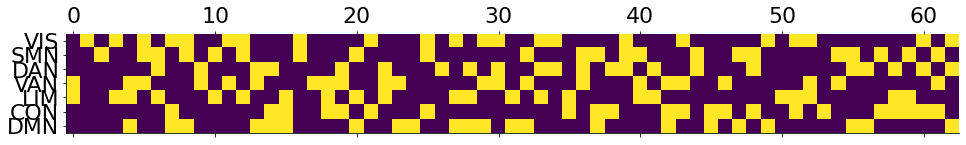

In [161]:
print(np.sort(np.array(pred_results).squeeze()[:, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results).squeeze()[:, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys());

0: Fisher Z transformation
Control connectivity
r=0.059 mse=189.601 rmse=13.77 mae=10.714
1: Fisher Z transformation
Control connectivity
r=0.11 mse=182.908 rmse=13.524 mae=10.585
2: Fisher Z transformation
Control connectivity
r=0.161 mse=179.293 rmse=13.39 mae=10.501
3: Fisher Z transformation
Control connectivity
r=0.108 mse=182.745 rmse=13.518 mae=10.754
4: Fisher Z transformation
Control connectivity
r=0.227 mse=170.152 rmse=13.044 mae=10.301
5: Fisher Z transformation
Control connectivity
r=0.271 mse=163.397 rmse=12.783 mae=10.126
6: Fisher Z transformation
Control connectivity
r=0.214 mse=170.052 rmse=13.04 mae=10.314
7: Fisher Z transformation
Control connectivity
r=0.152 mse=179.308 rmse=13.391 mae=10.542
8: Fisher Z transformation
Control connectivity
r=0.208 mse=171.712 rmse=13.104 mae=10.426
9: Fisher Z transformation
Control connectivity
r=0.096 mse=184.502 rmse=13.583 mae=10.688
10: Fisher Z transformation
Control connectivity
r=0.012 mse=195.631 rmse=13.987 mae=11.04
11:

([<matplotlib.axis.YTick at 0x7f8dbef33cc0>,
 [Text(0, 0, 'VIS'),
  Text(0, 1, 'SMN'),
  Text(0, 2, 'DAN'),
  Text(0, 3, 'VAN'),
  Text(0, 4, 'LIM'),
  Text(0, 5, 'CON'),
  Text(0, 6, 'DMN')])

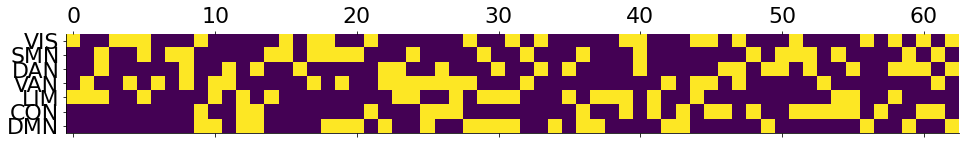

In [163]:
pred_results_cont = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, control=controls[:, -1])
sio.savemat('./Prediction_Results_templates_recont_cont.mat', {'Res': pred_results_cont})
print(np.sort(np.array(pred_results_cont).squeeze()[:, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cont).squeeze()[:, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())

In [159]:
pred_results_sum = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, reconst_method='sum')
sio.savemat('./Prediction_Results_templates_recont_sum.mat', {'Res': pred_results_sum})

r=-0.019 mse=203.544 rmse=14.267 mae=11.314
r=0.104 mse=189.415 rmse=13.763 mae=10.902
r=0.063 mse=195.241 rmse=13.973 mae=10.948
r=0.216 mse=171.372 rmse=13.091 mae=10.489
r=0.259 mse=167.785 rmse=12.953 mae=10.242
r=0.073 mse=189.029 rmse=13.749 mae=10.919
r=-0.051 mse=203.371 rmse=14.261 mae=11.394
r=0.071 mse=190.764 rmse=13.812 mae=10.98
r=0.028 mse=196.046 rmse=14.002 mae=11.101
r=0.067 mse=188.764 rmse=13.739 mae=10.947
r=0.035 mse=198.721 rmse=14.097 mae=11.381
r=0.078 mse=188.674 rmse=13.736 mae=10.478
r=0.112 mse=183.953 rmse=13.563 mae=10.871
r=0.252 mse=167.848 rmse=12.956 mae=10.09
r=0.075 mse=191.295 rmse=13.831 mae=10.933
r=-0.054 mse=214.601 rmse=14.649 mae=11.696
r=0.259 mse=166.606 rmse=12.908 mae=10.009
r=0.186 mse=176.288 rmse=13.277 mae=10.351
r=-0.06 mse=211.494 rmse=14.543 mae=11.802
r=0.121 mse=187.832 rmse=13.705 mae=10.788
r=0.195 mse=175.409 rmse=13.244 mae=10.173
r=0.069 mse=190.585 rmse=13.805 mae=10.729
r=-0.119 mse=217.789 rmse=14.758 mae=11.598
r=0.19 ms

[-0.1193722  -0.09513541 -0.05973963 -0.05409338 -0.05101925 -0.03129577
 -0.01863292 -0.01066949 -0.00928032  0.02372027  0.02782279  0.03473127
  0.03531575  0.06331299  0.06725879  0.0688458   0.07147009  0.07295598
  0.07479719  0.07772426  0.07796184  0.08961901  0.09204605  0.10110174
  0.10354533  0.10493157  0.106679    0.10801417  0.10831772  0.11176052
  0.11547575  0.11893016  0.11928943  0.11967179  0.12129112  0.12937326
  0.13521469  0.14879801  0.15116355  0.16757367  0.16934655  0.17762744
  0.18123493  0.18217341  0.18565705  0.18566532  0.18952679  0.19032175
  0.19527829  0.20462321  0.21521592  0.21571527  0.22482683  0.22483396
  0.23444898  0.24846268  0.25185239  0.25925049  0.25947633  0.26213626
  0.2672029   0.27842248  0.36539225]


([<matplotlib.axis.YTick at 0x7f8dbe237080>,
 [Text(0, 0, 'VIS'),
  Text(0, 1, 'SMN'),
  Text(0, 2, 'DAN'),
  Text(0, 3, 'VAN'),
  Text(0, 4, 'LIM'),
  Text(0, 5, 'CON'),
  Text(0, 6, 'DMN')])

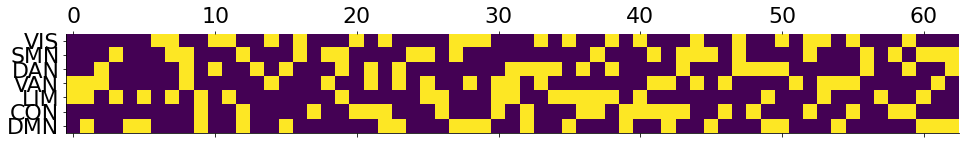

In [162]:
print(np.sort(np.array(pred_results_sum).squeeze()[:, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_sum).squeeze()[:, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys());

0: Control connectivity
r=-0.045 mse=209.797 rmse=14.484 mae=11.475
1: Control connectivity
r=0.105 mse=189.703 rmse=13.773 mae=10.766
2: Control connectivity
r=0.05 mse=197.84 rmse=14.066 mae=11.139
3: Control connectivity
r=0.188 mse=175.797 rmse=13.259 mae=10.605
4: Control connectivity
r=0.173 mse=181.868 rmse=13.486 mae=10.853
5: Control connectivity
r=0.153 mse=181.134 rmse=13.459 mae=10.634
6: Control connectivity
r=0.013 mse=196.335 rmse=14.012 mae=10.98
7: Control connectivity
r=0.073 mse=190.234 rmse=13.793 mae=10.923
8: Control connectivity
r=0.021 mse=195.475 rmse=13.981 mae=11.169
9: Control connectivity
r=0.13 mse=182.095 rmse=13.494 mae=10.699
10: Control connectivity
r=-0.011 mse=207.161 rmse=14.393 mae=11.699
11: Control connectivity
r=0.104 mse=189.386 rmse=13.762 mae=10.531
12: Control connectivity
r=0.037 mse=195.54 rmse=13.984 mae=11.089
13: Control connectivity
r=0.126 mse=184.618 rmse=13.587 mae=10.644
14: Control connectivity
r=-0.048 mse=212.688 rmse=14.584 mae

([<matplotlib.axis.YTick at 0x7f8dbeb310f0>,
 [Text(0, 0, 'VIS'),
  Text(0, 1, 'SMN'),
  Text(0, 2, 'DAN'),
  Text(0, 3, 'VAN'),
  Text(0, 4, 'LIM'),
  Text(0, 5, 'CON'),
  Text(0, 6, 'DMN')])

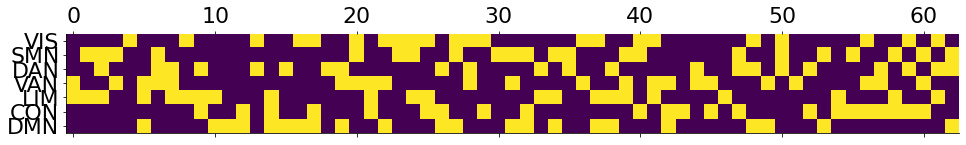

In [164]:
pred_results_sum_cont = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, control=controls[:, -1], reconst_method='sum')
sio.savemat('./Prediction_Results_templates_recont_sum_cont.mat', {'Res': pred_results_sum_cont})
print(np.sort(np.array(pred_results_sum_cont).squeeze()[:, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_sum_cont).squeeze()[:, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())

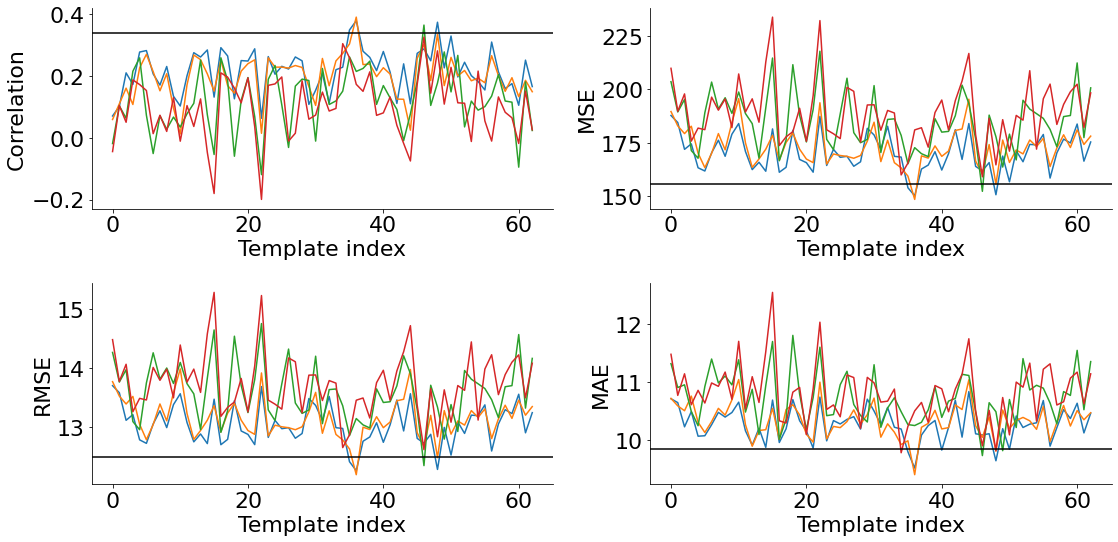

In [172]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=2)
orig_results = [.34, 155.97, 12.49, 9.84] # sFC
pred_metrics = ['Correlation', 'MSE', 'RMSE', 'MAE']
row, col = 0, 0
for i in range(4):
    ax[row, col].plot(np.array(pred_results)[..., i])
    ax[row, col].plot(np.array(pred_results_cont)[..., i])
    ax[row, col].plot(np.array(pred_results_sum)[..., i])
    ax[row, col].plot(np.array(pred_results_sum_cont)[..., i])
    ax[row, col].axhline(orig_results[i], c='k') 
    ax[row, col].set_ylabel(pred_metrics[i])
    ax[row, col].set_xlabel('Template index')
    col += 1
    if col == 2:
        row += 1
        col = 0
plt.tight_layout()

In [177]:
# Correlations between FC calculation and template prediction

print('Corr, Corr Cont', pearsonr(np.array(pred_results)[..., i].squeeze(), np.array(pred_results_cont)[..., i].squeeze()))
print('Corr, Sum', pearsonr(np.array(pred_results)[..., i].squeeze(), np.array(pred_results_sum)[..., i].squeeze()))
print('Corr, Sum Cont', pearsonr(np.array(pred_results)[..., i].squeeze(), np.array(pred_results_sum_cont)[..., i].squeeze()))


print('Corr Cont, Sum', pearsonr(np.array(pred_results_cont)[..., i].squeeze(), np.array(pred_results_sum)[..., i].squeeze()))
print('Corr Cont, Sum Cont', pearsonr(np.array(pred_results_cont)[..., i].squeeze(), np.array(pred_results_sum_cont)[..., i].squeeze()))

print('Sum Cont, Sum', pearsonr(np.array(pred_results_sum)[..., i].squeeze(), np.array(pred_results_sum_cont)[..., i].squeeze()))

Corr, Corr Cont (0.8242220618001277, 1.0532637451107455e-16)
Corr, Sum (0.515840135730125, 1.5126527483678197e-05)
Corr, Sum Cont (0.5187734117587024, 1.3262756854445852e-05)
Corr Cont, Sum (0.5338748330248989, 6.608417548285454e-06)
Corr Cont, Sum Cont (0.5616802053281329, 1.6723009550758484e-06)
Sum Cont, Sum (0.6407474737358623, 1.54836181144006e-08)


## Similarity to sFC

In [178]:
def similarity_reconstruction_to_sFC(raw, sFC, mi, nb_tfs):
    nb_templates, nb_samples, _ = mi.shape
    recont_sims_corr, recont_sims_sum = [], []
    for template_i in range(nb_templates):
        recont_FC = create_fc_from_template(raw, template_i, mi, nb_tfs, 'corr')
        r, p = pearsonr(recont_FC.ravel(), sFC.ravel())
        recont_sims_corr.append(r)
        recont_FC = create_fc_from_template(raw, template_i, mi, nb_tfs, 'sum')
        r, p = pearsonr(recont_FC.ravel(), sFC.ravel())
        recont_sims_sum.append(r)
    return recont_sims_corr, recont_sims_sum

In [180]:
recont_sims_corr, recont_sims_sum = similarity_reconstruction_to_sFC(raw_645_zscored, static_con, mi, nb_tfs=44)

Text(0, 0.5, 'Reconstruction sim')

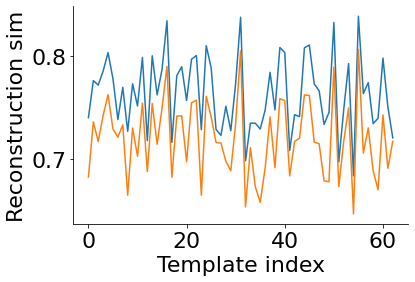

In [181]:
plt.plot(recont_sims_corr, label='corr')
plt.plot(recont_sims_sum, label='sum')
plt.xlabel('Template index')
plt.ylabel('Reconstruction sim')

In [183]:
print('Corr as Recont: Pred, Sim', pearsonr(np.array(pred_results)[..., i].squeeze(), recont_sims_corr))
print('Sum as Recont: Pred, Sim', pearsonr(np.array(pred_results_sum)[..., i].squeeze(), recont_sims_sum))

Corr as Recont: Pred, Sim (0.009571729874881606, 0.9406494884038097)
Sum as Recont: Pred, Sim (0.10052595840657483, 0.4330924200378621)


## Similarity to template

In [195]:
def template_similarity(raw, sFC, mi, templates, nb_tfs):
    nb_templates, nb_samples, _ = mi.shape
    recont_sims_temp_corr, recont_sims_temp_sum = [], []
    triu_indices = np.triu_indices(sFC.shape[-1], k = 1)
    for template_i, template in enumerate(templates):
        print(template_i, end='; ')
        recont_FC = create_fc_from_template(raw, template_i, mi, nb_tfs, 'corr')
        reshaped_rFCs = []
        for rFC in recont_FC:
            reshaped_rFCs.append(rFC[triu_indices])
        # print(np.array(reshaped_rFCs).shape)
        mi_ = mutual_info_classif(np.array(reshaped_rFCs).T, template[triu_indices])
        recont_sims_temp_corr.append(mi_)
        recont_FC = create_fc_from_template(raw, template_i, mi, nb_tfs, 'sum')
        reshaped_rFCs = []
        for rFC in recont_FC:
            reshaped_rFCs.append(rFC[triu_indices])
        mi_ = mutual_info_classif(np.array(reshaped_rFCs).T, template[triu_indices])
        recont_sims_temp_sum.append(mi_)
    return recont_sims_temp_corr, recont_sims_temp_sum 

In [196]:
recont_sims_temp_corr, recont_sims_temp_sum  = template_similarity(raw_645_zscored, static_con, mi, templates, nb_tfs=44)

0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 

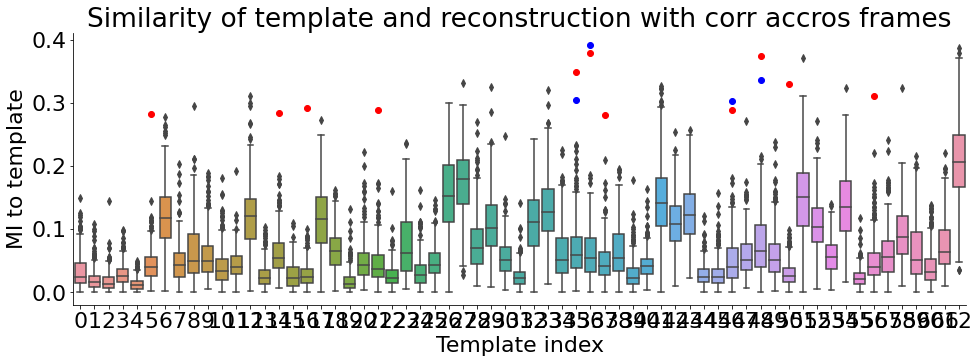

In [215]:
# boxplots show similarity of reconstructed matrices with template across individuals. 
# Red dots indicate prediction with reconstructed matrix without controlling for mean fd and blue with control
plt.figure(figsize=(16, 5))
sns.boxplot(data=np.array(recont_sims_temp_corr).T)
plt.xlabel('Template index')
plt.ylabel('MI to template')
best_predicting_templates = np.where(np.array(pred_results).squeeze()[:, 0] > .28)[0]
for temp in best_predicting_templates:
    # plt.axvline(temp, color='red')
    plt.scatter(temp,np.array(pred_results).squeeze()[temp, 0], color='red')
    
best_predicting_templates = np.where(np.array(pred_results_cont).squeeze()[:, 0] > .28)[0]
for temp in best_predicting_templates:
    plt.scatter(temp,np.array(pred_results_cont).squeeze()[temp, 0], color='blue')
plt.title('Similarity of template and reconstruction with corr accros frames');

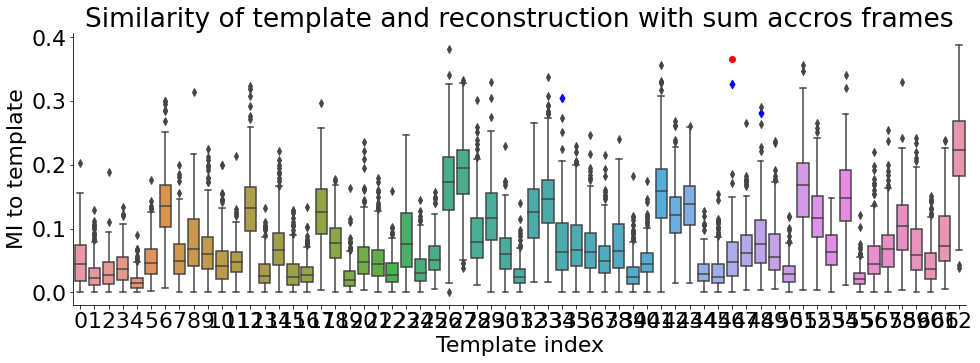

In [216]:
# boxplots show similarity of reconstructed matrices with template across individuals. 
# Red dots indicate prediction with reconstructed matrix without controlling for mean fd and blue with control
plt.figure(figsize=(16, 5))
sns.boxplot(data=np.array(recont_sims_temp_sum).T)
plt.xlabel('Template index')
plt.ylabel('MI to template')
best_predicting_templates = np.where(np.array(pred_results_sum).squeeze()[:, 0] > .28)[0]
for temp in best_predicting_templates:
    # plt.axvline(temp, color='red')
    plt.scatter(temp,np.array(pred_results_sum).squeeze()[temp, 0], color='red')
    
best_predicting_templates = np.where(np.array(pred_results_sum_cont).squeeze()[:, 0] > .28)[0]
for temp in best_predicting_templates:
    plt.scatter(temp,np.array(pred_results_sum_cont).squeeze()[temp, 0], color='blue', marker='d')
plt.title('Similarity of template and reconstruction with sum accros frames');

## CPM

In [225]:
iq_pred_cpm, orig_iq_cpm, _ = CPM(stat_con_cont, fs_iq, None, split=len(fs_iq))
orig_res_cpm = calc_all_metrics(iq_pred_cpm, orig_iq_cpm, print_metrics=True)

r=0.269 mse=171.451 rmse=13.094 mae=10.488
r=0.259 mse=174.207 rmse=13.199 mae=10.435


0: Fisher Z transformation
r=0.076 mse=196.716 rmse=14.026 mae=11.151
r=0.128 mse=187.713 rmse=13.701 mae=10.914
1: Fisher Z transformation
r=0.21 mse=180.014 rmse=13.417 mae=10.488
r=-0.006 mse=209.128 rmse=14.461 mae=11.24
2: Fisher Z transformation
r=0.233 mse=170.914 rmse=13.073 mae=10.47
r=0.158 mse=186.062 rmse=13.64 mae=10.826
3: Fisher Z transformation
r=-0.22 mse=251.329 rmse=15.853 mae=12.517
r=0.09 mse=195.003 rmse=13.964 mae=11.387
4: Fisher Z transformation
r=0.174 mse=184.759 rmse=13.593 mae=10.878
r=0.053 mse=200.082 rmse=14.145 mae=10.885
5: Fisher Z transformation
r=-0.073 mse=222.853 rmse=14.928 mae=11.991
r=0.14 mse=184.983 rmse=13.601 mae=10.758
6: Fisher Z transformation
r=0.064 mse=195.8 rmse=13.993 mae=11.082
r=0.102 mse=188.153 rmse=13.717 mae=10.903
7: Fisher Z transformation
r=0.219 mse=175.55 rmse=13.25 mae=10.521
r=0.065 mse=191.991 rmse=13.856 mae=10.914
8: Fisher Z transformation
r=0.197 mse=173.783 rmse=13.183 mae=10.328
r=0.024 mse=196.687 rmse=14.025 ma

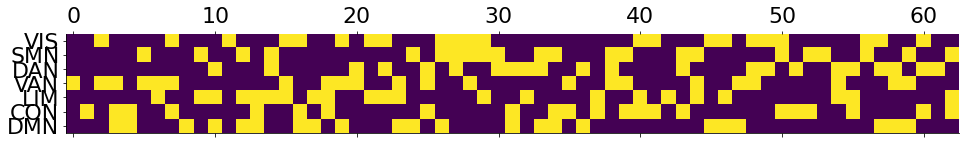

Neg NW [-0.12825047 -0.10142979 -0.09417329 -0.07291423 -0.03590944 -0.03367512
 -0.0267179  -0.01268784 -0.00645548  0.00467616  0.00685473  0.02054013
  0.02174136  0.02392038  0.0276508   0.03461772  0.04014629  0.04428156
  0.04709538  0.05344117  0.05386679  0.05528532  0.05974632  0.06503087
  0.06969833  0.07195188  0.07490918  0.07617677  0.07660196  0.0836771
  0.08509419  0.08746641  0.08984226  0.09305104  0.09496496  0.09619065
  0.10244214  0.10300464  0.10330296  0.10986532  0.10986536  0.11691471
  0.12136265  0.1230966   0.1256887   0.1277472   0.14031418  0.14657442
  0.15137689  0.15286485  0.15688166  0.15840756  0.16507813  0.16557847
  0.16817947  0.20617426  0.20972085  0.20993871  0.21176338  0.23321789
  0.23501274  0.24191178  0.25372689]


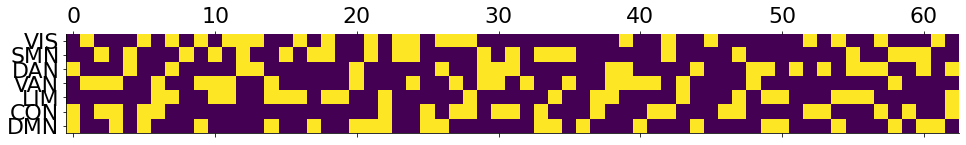

In [228]:
pred_results_cpm = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, model='cpm')
sio.savemat('./Prediction_Results_templates_CPM_recont_corr.mat', {'Res': pred_results_cpm})
print('Pos NW', np.sort(np.array(pred_results_cpm)[:, 0, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm)[:, 0, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();
print('Neg NW', np.sort(np.array(pred_results_cpm)[:, 1, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm)[:, 1, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();

0: Fisher Z transformation
Control connectivity
r=0.115 mse=191.716 rmse=13.846 mae=10.887
r=-0.017 mse=210.286 rmse=14.501 mae=11.445
1: Fisher Z transformation
Control connectivity
r=0.201 mse=181.343 rmse=13.466 mae=10.53
r=-0.047 mse=216.547 rmse=14.716 mae=11.37
2: Fisher Z transformation
Control connectivity
r=0.213 mse=173.581 rmse=13.175 mae=10.567
r=0.185 mse=180.892 rmse=13.45 mae=10.621
3: Fisher Z transformation
Control connectivity
r=-0.05 mse=217.843 rmse=14.76 mae=11.636
r=0.18 mse=180.52 rmse=13.436 mae=10.905
4: Fisher Z transformation
Control connectivity
r=0.178 mse=182.959 rmse=13.526 mae=10.745
r=0.032 mse=202.799 rmse=14.241 mae=10.931
5: Fisher Z transformation
Control connectivity
r=0.061 mse=200.282 rmse=14.152 mae=11.244
r=0.16 mse=182.191 rmse=13.498 mae=10.701
6: Fisher Z transformation
Control connectivity
r=0.069 mse=197.032 rmse=14.037 mae=11.135
r=0.151 mse=181.551 rmse=13.474 mae=10.641
7: Fisher Z transformation
Control connectivity
r=0.203 mse=178.095

Control connectivity
r=-0.075 mse=213.808 rmse=14.622 mae=11.764
r=-0.015 mse=206.751 rmse=14.379 mae=11.331
62: Fisher Z transformation
Control connectivity
r=0.098 mse=191.437 rmse=13.836 mae=10.89
r=0.1 mse=186.796 rmse=13.667 mae=10.576
Pos NW [-0.07510323 -0.04980357 -0.02404093  0.00961601  0.01253039  0.01473717
  0.01636288  0.02020864  0.03051281  0.05294017  0.05439913  0.06084291
  0.06104477  0.06372648  0.06688141  0.06905692  0.08167835  0.0861188
  0.08710105  0.08719921  0.08796022  0.09661613  0.09817587  0.10300364
  0.11411667  0.11513965  0.1160418   0.11648461  0.12306066  0.12554196
  0.12882669  0.13772966  0.14150636  0.14640112  0.1487985   0.1525059
  0.15400925  0.1542524   0.15425614  0.16932472  0.1693275   0.17847808
  0.18326158  0.18723975  0.18964816  0.1915679   0.19378686  0.19552163
  0.19626394  0.2006314   0.20132236  0.20134219  0.20345192  0.20545408
  0.21138942  0.21308828  0.21310612  0.21641227  0.22268737  0.22672749
  0.23475699  0.23576666

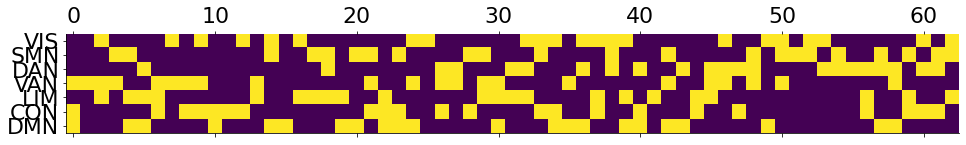

Neg NW [-0.17372458 -0.04989338 -0.04668382 -0.02574249 -0.01699932 -0.01684796
 -0.01621796 -0.01549773 -0.00869202  0.00623479  0.00824515  0.01301349
  0.01456887  0.01598418  0.02058997  0.02561111  0.02817261  0.0315452
  0.0315704   0.04096807  0.05381584  0.05799912  0.06426038  0.06675075
  0.07044188  0.07601936  0.0765097   0.08629567  0.08808886  0.08829739
  0.09413134  0.09754519  0.09890826  0.1003731   0.10105849  0.10855931
  0.11478079  0.11564961  0.11715194  0.11987649  0.12311783  0.1235689
  0.12504418  0.12532803  0.13272093  0.13712849  0.13883459  0.15032726
  0.15139334  0.15696481  0.16018661  0.16810594  0.17730363  0.17994251
  0.18042868  0.18518513  0.1942653   0.19532179  0.20991408  0.21272635
  0.22243258  0.2387623   0.24466163]


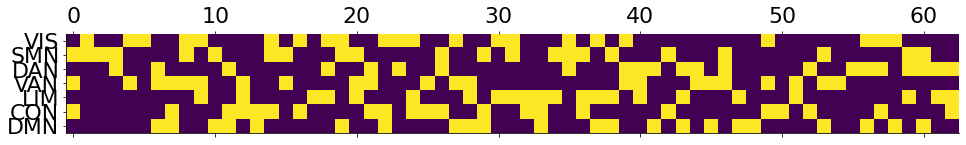

In [229]:
pred_results_cpm_cont = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, model='cpm', 
                                              control=controls[:, -1])
sio.savemat('./Prediction_Results_templates_CPM_recont_corr_cont.mat', {'Res': pred_results_cpm_cont})
print('Pos NW', np.sort(np.array(pred_results_cpm_cont)[:, 0, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm_cont)[:, 0, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();
print('Neg NW', np.sort(np.array(pred_results_cpm_cont)[:, 1, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm_cont)[:, 1, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();

0: r=0.033 mse=197.289 rmse=14.046 mae=11.084
r=-0.177 mse=226.562 rmse=15.052 mae=11.882
1: r=0.179 mse=183.654 rmse=13.552 mae=10.588
r=0.143 mse=181.703 rmse=13.48 mae=10.558
2: r=0.241 mse=168.721 rmse=12.989 mae=10.315
r=0.152 mse=185.106 rmse=13.605 mae=10.586
3: r=-0.051 mse=214.68 rmse=14.652 mae=11.746
r=0.194 mse=175.867 rmse=13.261 mae=10.825
4: r=0.103 mse=189.855 rmse=13.779 mae=10.825
r=0.09 mse=192.654 rmse=13.88 mae=10.771
5: r=0.067 mse=194.531 rmse=13.947 mae=11.015
r=0.096 mse=188.094 rmse=13.715 mae=10.916
6: r=0.196 mse=176.757 rmse=13.295 mae=10.52
r=0.157 mse=179.752 rmse=13.407 mae=10.648
7: r=0.005 mse=205.165 rmse=14.324 mae=11.376
r=-0.048 mse=205.156 rmse=14.323 mae=11.292
8: r=0.168 mse=174.087 rmse=13.194 mae=10.378
r=0.118 mse=179.511 rmse=13.398 mae=10.472
9: r=0.007 mse=210.23 rmse=14.499 mae=11.582
r=0.103 mse=191.749 rmse=13.847 mae=11.014
10: r=0.071 mse=186.501 rmse=13.657 mae=10.755
r=0.121 mse=186.213 rmse=13.646 mae=10.49
11: r=0.044 mse=199.125 

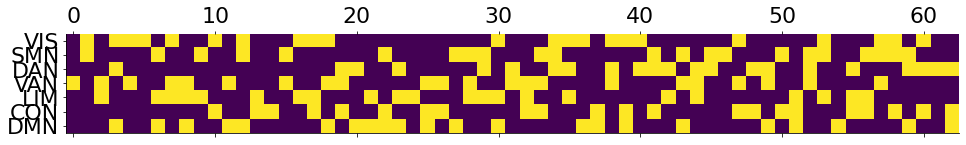

Neg NW [-0.17708224 -0.17190354 -0.08105472 -0.06363055 -0.04827138 -0.03946576
 -0.02752609 -0.00293852  0.00149032  0.025883    0.02653353  0.02905078
  0.03897821  0.04026831  0.0410342   0.04317838  0.04395912  0.04612861
  0.05058807  0.05640429  0.05824602  0.06219005  0.07204332  0.07991484
  0.08449635  0.0853885   0.08774313  0.08969485  0.09143918  0.09338632
  0.0963443   0.10095498  0.10274377  0.10512762  0.10853124  0.1179188
  0.11863959  0.11923375  0.12070729  0.12113781  0.12152939  0.12460377
  0.13004344  0.13673204  0.13898795  0.14257544  0.14273993  0.1446741
  0.14547297  0.1516884   0.1521485   0.15598233  0.15691495  0.16016799
  0.17120246  0.18639883  0.19381946  0.19447827  0.1951144   0.19860786
  0.20285342  0.23112064  0.23626015]


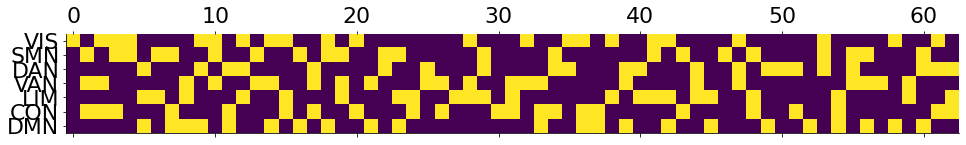

In [230]:
pred_results_cpm_sum = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, model='cpm', 
                                             reconst_method='sum')
sio.savemat('./Prediction_Results_templates_CPM_recont_sum.mat', {'Res': pred_results_cpm_sum})
print('Pos NW', np.sort(np.array(pred_results_cpm_sum)[:, 0, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm_sum)[:, 0, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();
print('Neg NW', np.sort(np.array(pred_results_cpm_sum)[:, 1, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm_sum)[:, 1, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();


0: Control connectivity
r=-0.03 mse=208.456 rmse=14.438 mae=11.426
r=-0.153 mse=221.827 rmse=14.894 mae=11.696
1: Control connectivity
r=0.205 mse=179.576 rmse=13.401 mae=10.452
r=0.077 mse=192.763 rmse=13.884 mae=10.823
2: Control connectivity
r=0.242 mse=168.371 rmse=12.976 mae=10.346
r=0.134 mse=186.567 rmse=13.659 mae=10.783
3: Control connectivity
r=-0.001 mse=206.624 rmse=14.374 mae=11.463
r=0.203 mse=174.5 rmse=13.21 mae=10.744
4: Control connectivity
r=0.0 mse=202.28 rmse=14.223 mae=11.336
r=-0.027 mse=207.029 rmse=14.389 mae=11.227
5: Control connectivity
r=0.069 mse=196.71 rmse=14.025 mae=11.12
r=0.129 mse=184.069 rmse=13.567 mae=10.76
6: Control connectivity
r=0.176 mse=180.118 rmse=13.421 mae=10.671
r=0.104 mse=186.087 rmse=13.641 mae=10.865
7: Control connectivity
r=0.051 mse=201.528 rmse=14.196 mae=11.098
r=-0.17 mse=223.607 rmse=14.954 mae=12.011
8: Control connectivity
r=0.184 mse=172.526 rmse=13.135 mae=10.418
r=0.109 mse=182.498 rmse=13.509 mae=10.584
9: Control conne

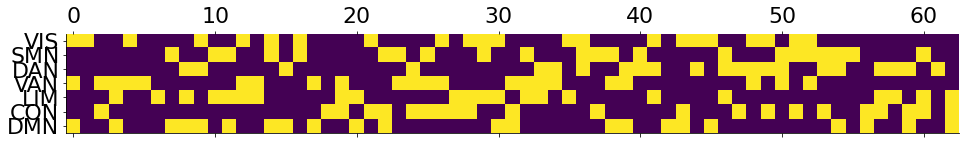

Neg NW [-0.22475189 -0.17012012 -0.15299826 -0.13470846 -0.10538639 -0.08261457
 -0.06736655 -0.05902668 -0.027204   -0.02654863 -0.01699871 -0.01534554
 -0.0125657  -0.00178605  0.00463856  0.0172348   0.03955005  0.04767431
  0.05478719  0.05685428  0.05898559  0.06045931  0.06316751  0.07650463
  0.07674385  0.08235639  0.08426766  0.08798962  0.09104553  0.09126429
  0.09434323  0.09588561  0.10203214  0.10443654  0.10712278  0.10754409
  0.10899143  0.11297774  0.1239264   0.12887421  0.13009366  0.13350169
  0.13419732  0.1374999   0.14470944  0.15262618  0.15747361  0.16065248
  0.16277697  0.16404454  0.16823808  0.17024816  0.17553864  0.17570906
  0.18552045  0.1896969   0.20033716  0.20304957  0.20999196  0.21595004
  0.2188995   0.23228717  0.24924466]


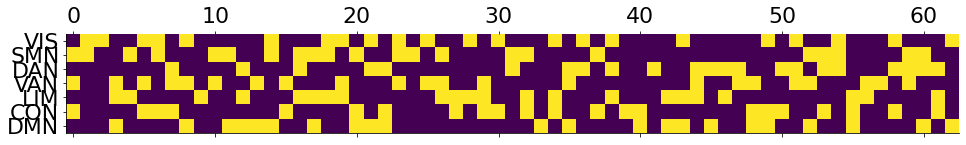

In [231]:
pred_results_cpm_sum_cont = predict_from_template(templates, raw_645_zscored, fs_iq, mi, nb_tfs=44, model='cpm', 
                                                  control=controls[:, -1], reconst_method='sum')
sio.savemat('./Prediction_Results_templates_CPM_recont_sum_cont.mat', {'Res': pred_results_cpm_sum_cont})
print('Pos NW', np.sort(np.array(pred_results_cpm_sum_cont)[:, 0, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm_sum_cont)[:, 0, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();
print('Neg NW', np.sort(np.array(pred_results_cpm_sum_cont)[:, 1, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_cpm_sum_cont)[:, 1, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())
plt.show();

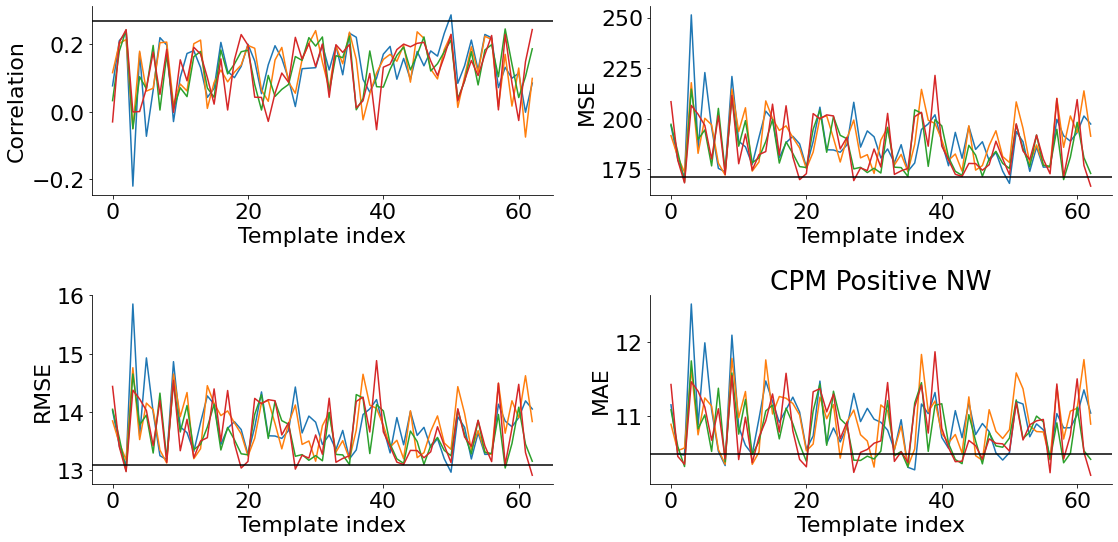

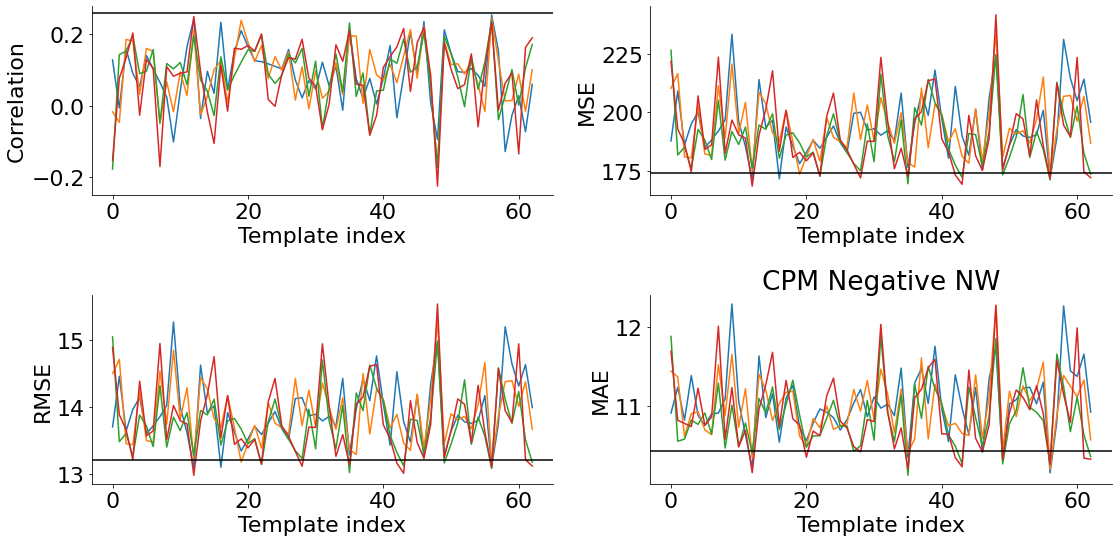

In [232]:
pred_metrics = ['Correlation', 'MSE', 'RMSE', 'MAE']
nw_models = ['Positive', 'Negative']
for j in range(2):
    fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=2)
    row, col = 0, 0
    for i in range(4):
        ax[row, col].plot(np.array(pred_results_cpm)[...,j, i])
        ax[row, col].plot(np.array(pred_results_cpm_cont)[...,j, i])
        ax[row, col].plot(np.array(pred_results_cpm_sum)[...,j, i])
        ax[row, col].plot(np.array(pred_results_cpm_sum_cont)[...,j, i])
        ax[row, col].axhline(orig_res_cpm[j, i], c='k') 
        ax[row, col].set_ylabel(pred_metrics[i])
        ax[row, col].set_xlabel('Template index')
        col += 1
        if col == 2:
            row += 1
            col = 0
    plt.title(f'CPM {nw_models[j]} NW')
    plt.tight_layout()
    plt.show();

# Compare MI with & without bipartition

In [368]:
pred_results_bi = predict_from_template(templates, raw_645_zscored, fs_iq, mut_info_cluster, nb_tfs=44)
sio.savemat('./Prediction_Results_bipart_templates_recont.mat', {'Res': pred_results_bi})
print(np.sort(np.array(pred_results_bi).squeeze()[:, 0]), np.argsort(np.array(pred_results_bi).squeeze()[:, 0]))
plt.matshow(bin_nws[np.argsort(np.array(pred_results_bi).squeeze()[:, 0])].T)
plt.yticks(np.arange(len(NETWORKS)), NETWORKS.keys())

0: Fisher Z transformation
r=0.128 mse=179.479 rmse=13.397 mae=10.724
1: Fisher Z transformation
r=0.03 mse=189.721 rmse=13.774 mae=10.863
2: Fisher Z transformation
r=0.083 mse=184.326 rmse=13.577 mae=10.73
3: Fisher Z transformation
r=0.187 mse=172.563 rmse=13.136 mae=10.367
4: Fisher Z transformation
r=0.053 mse=187.018 rmse=13.675 mae=10.74
5: Fisher Z transformation
r=0.206 mse=169.137 rmse=13.005 mae=10.279
6: Fisher Z transformation
r=0.214 mse=169.232 rmse=13.009 mae=10.201
7: Fisher Z transformation
r=0.099 mse=183.003 rmse=13.528 mae=10.462
8: Fisher Z transformation
r=0.184 mse=173.689 rmse=13.179 mae=10.368
9: Fisher Z transformation
r=0.004 mse=193.214 rmse=13.9 mae=10.78
10: Fisher Z transformation
r=0.11 mse=180.871 rmse=13.449 mae=10.803
11: Fisher Z transformation
r=0.267 mse=163.392 rmse=12.782 mae=10.039
12: Fisher Z transformation
r=0.205 mse=170.552 rmse=13.06 mae=10.065
13: Fisher Z transformation
r=0.303 mse=159.475 rmse=12.628 mae=9.972
14: Fisher Z transformati

KeyboardInterrupt: 

In [369]:
print(1)

1


In [375]:
pred_res_bipart_corr = sio.loadmat('./pred_results/NKI/Prediction_Results_bipart_templates_recont_corr.mat')['Res'].squeeze()
pred_res_bipart_corr_cont = sio.loadmat('./pred_results/NKI/Prediction_Results_bipart_templates_recont_corr_cont.mat')['Res'].squeeze()
pred_res_bipart_sum = sio.loadmat('./pred_results/NKI/Prediction_Results_bipart_templates_recont_sum.mat')['Res'].squeeze()
pred_res_bipart_sum_cont = sio.loadmat('./pred_results/NKI/Prediction_Results_bipart_templates_recont_sum_cont.mat')['Res'].squeeze()

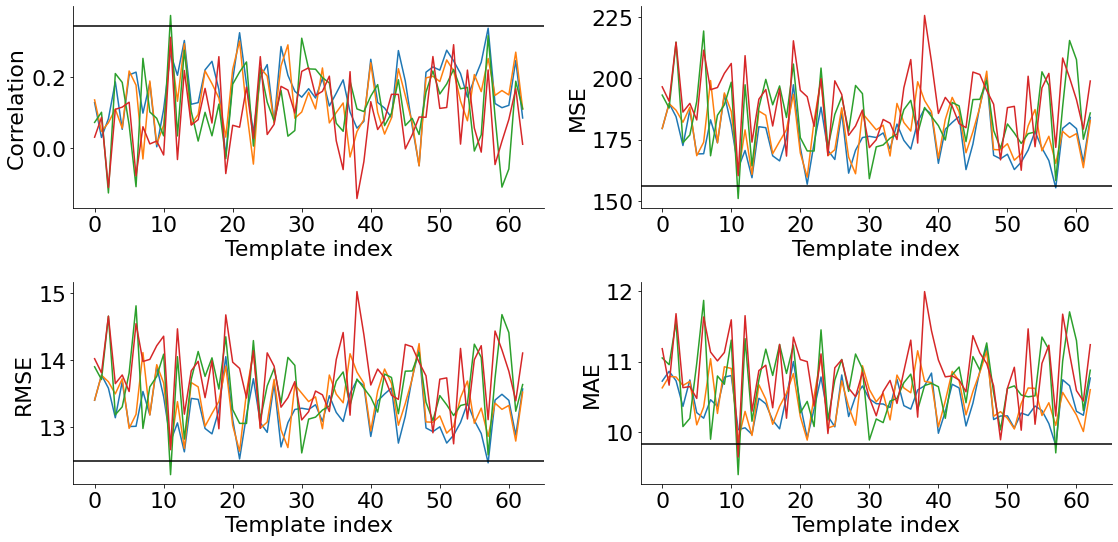

In [379]:
pred_metrics = ['Correlation', 'MSE', 'RMSE', 'MAE']
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=2)
row, col = 0, 0
for i in range(4):
    ax[row, col].plot(np.array(pred_res_bipart_corr)[..., i])
    ax[row, col].plot(np.array(pred_res_bipart_corr_cont)[..., i])
    ax[row, col].plot(np.array(pred_res_bipart_sum)[...,i])
    ax[row, col].plot(np.array(pred_res_bipart_sum_cont)[...,i])
    ax[row, col].axhline(orig_cmep[0, i], c='k') 
    ax[row, col].set_ylabel(pred_metrics[i])
    ax[row, col].set_xlabel('Template index')
    col += 1
    if col == 2:
        row += 1
        col = 0
plt.tight_layout()
plt.show();

In [ ]:
def init_population(n, c):
    '''n = Number of individuals, c = number of features'''
    population = np.array([[math.ceil(e) for ea in pop] for pop in (np.random.rand(n,c)-0.5)])
    return population

"""def single_point_crossover(population):
    r,c, n = population.shape[0], population.shape[1], np.random.randint(1,population.shape[1])         
    for i in range(0,r,2):                
        population[i], population[i+1] = np.append(population[i][0:n],population[i+1][n:c]),np.append(population[i+1][0:n],population[i][n:c])        
    return population



def flip_mutation(population):
    return population.max() - population"""

def crossover(population):
    nb_individs, nb_feats = population.shape[0], population.shape[1]
    mutation_rate = 1/nb_feats
    offsprings = np.zeros((int(nb_individs*2), nb_feats), dtype=np.int) 
    counter = 0
    for i in range(0,nb_individs,2):
        for j in range(4):
            rand_select = np.random.choice(2, nb_feats)
            not_rand_select = np.logical_not(rand_select).astype(int)
            offsprings[counter] = population[i] * rand_select + population[i+1] * not_rand_select  
            
            mutatations = np.array([np.random.rand(1)[0] for _ in range(nb_feats)])
            feats_mutate = np.where(mutatations < mutation_rate)
            offsprings[counter][feats_mutate] = np.logical_not(offsprings[counter][feats_mutate]).astype(int)
            counter += 1
    return offsprings

def select_best_individuals(population, fitness):
    # fitness sorted by best errror first then worst
    best_individ = np.argsort(fitness)[-len(fitness)//2:]
    new_pop = population[np.sort(best_individ)]
    return new_pop

def get_fitness(data, target, population):    
    fitness = []
    for individ in population:    
        individ = np.where(individ == 1)[0]
        selected_feats = data[:, individ]
        individ_fitness = predictive_model(selected_feats, target)                    
        fitness.append(individ_fitness)  
    return fitness
